# Normal distribution
* [1D](#1D)
* [2D no spatial covariance](#2D-no-spatial-covariance)
* [2D spatial covariance](#2D-spatial-covariance)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as la

## Model

In [3]:
def curve(x):
    return (x/10)**3 - 6*(x/10)**2 + 4*x/10 + 30

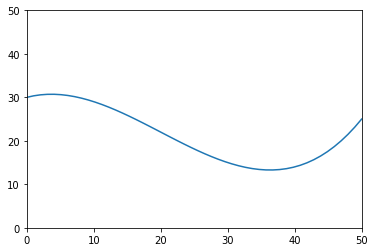

In [4]:
x = np.linspace(0, 50)
y = curve(x)

plt.figure()
plt.plot(x, y)
plt.xlim(0,50)
plt.ylim(0,50)
plt.show()

## Probability density function
\begin{align}
    {\displaystyle f(x)={\frac {1}{\sigma {\sqrt {2\pi }}}}e^{-{\frac {1}{2}}\left({\frac {x-\mu }{\sigma }}\right)^{2}}}
\end{align}

In [5]:
def normal(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - 0.5 * ( (x - mu)/sigma )**2 )

### 1D

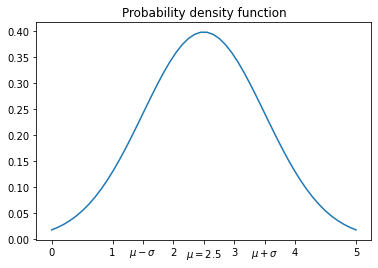

In [165]:
x = np.linspace(0,5)
y = normal(x, 2.5, 1.)

plt.figure()
plt.title('Probability density function')
plt.plot(x, y)
plt.xticks([0, 1, 2.5-1., 2.0, 2.5, 3, 2.5+1, 4, 5], [0, 1, '$\\mu-\\sigma$', 2, '$\\mu=2.5$', 3, '$\\mu+\\sigma$', 4, 5])
plt.show()

### 2D no spatial covariance

In [7]:
def generate_normal(i, j):
    v = curve(i)
    
    mu = np.ones_like(i, dtype=np.float64)
    type1 = v >= j
    mu[ type1 ] = 15.
    
    type2 = v < j
    mu[ type2 ] = 7.
    
    variance = np.zeros_like(i, dtype=np.float64)
    variance = np.abs(v - j)
    variance /= np.max(variance)
    variance = 1 - variance
    
    return mu, variance

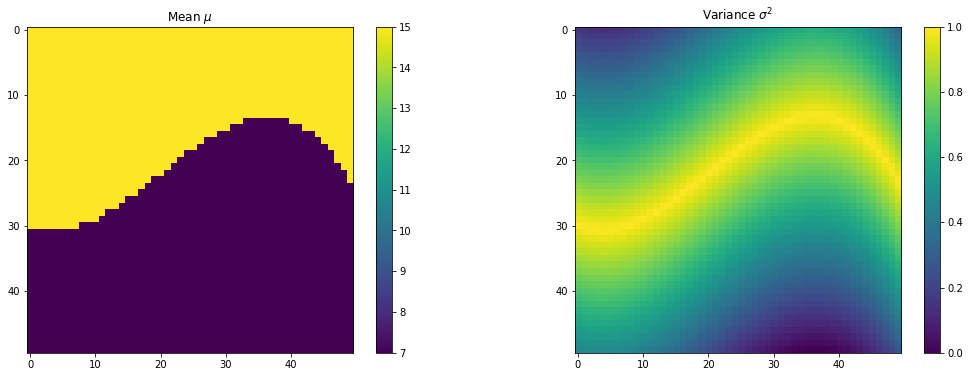

In [162]:
x = np.arange(50)
y = np.arange(50)
xx, yy = np.meshgrid(x, y)

mean, variance = generate_normal(xx, yy)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Mean $\mu$')
plt.imshow(mean)
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Variance $\sigma^2$')
plt.imshow(variance)
plt.colorbar()
plt.show()

#### Realization

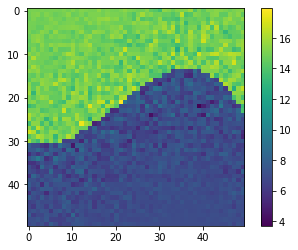

In [9]:
sample = np.random.normal(mean, variance)

plt.figure()
plt.imshow(sample)
plt.colorbar()
plt.show()

### 2D spatial covariance
\begin{align}
    {\displaystyle \operatorname {K} _{X_{i}X_{j}}=\operatorname {cov} [X_{i},X_{j}]=\operatorname {E} [(X_{i}-\operatorname {E} [X_{i}])(X_{j}-\operatorname {E} [X_{j}])]} \\
    {\displaystyle \operatorname {K} _{\mathbf {X} \mathbf {X} }={\begin{bmatrix}\mathrm {E} [(X_{1}-\operatorname {E} [X_{1}])(X_{1}-\operatorname {E} [X_{1}])]&\mathrm {E} [(X_{1}-\operatorname {E} [X_{1}])(X_{2}-\operatorname {E} [X_{2}])]&\cdots &\mathrm {E} [(X_{1}-\operatorname {E} [X_{1}])(X_{n}-\operatorname {E} [X_{n}])]\\\\\mathrm {E} [(X_{2}-\operatorname {E} [X_{2}])(X_{1}-\operatorname {E} [X_{1}])]&\mathrm {E} [(X_{2}-\operatorname {E} [X_{2}])(X_{2}-\operatorname {E} [X_{2}])]&\cdots &\mathrm {E} [(X_{2}-\operatorname {E} [X_{2}])(X_{n}-\operatorname {E} [X_{n}])]\\\\\vdots &\vdots &\ddots &\vdots \\\\\mathrm {E} [(X_{n}-\operatorname {E} [X_{n}])(X_{1}-\operatorname {E} [X_{1}])]&\mathrm {E} [(X_{n}-\operatorname {E} [X_{n}])(X_{2}-\operatorname {E} [X_{2}])]&\cdots &\mathrm {E} [(X_{n}-\operatorname {E} [X_{n}])(X_{n}-\operatorname {E} [X_{n}])]\end{bmatrix}}}
\end{align}

### Building the covariance matrix
This matrix is similar to the adjacency matrix $A$, as we model the influence of each point be limited by a range $r$. A good hint to derive them is the following:
\begin{align}
    {\boldsymbol  \mu }={\begin{pmatrix}\mu _{X}\\\mu _{Y}\end{pmatrix}},\quad {\boldsymbol  \Sigma }={\begin{pmatrix}\sigma _{X}^{2}&\rho \sigma _{X}\sigma _{Y}\\\rho \sigma _{X}\sigma _{Y}&\sigma _{Y}^{2}\end{pmatrix}},
\end{align}
while $\sigma_X > 0$ and $\sigma_Y > 0$ with a correlation $\rho$.

As a consequence of Gershgorin's Theorem, we know that the eigenvalues of a matrix 𝐴 live in balls $B(a_{ii}, \sum_{j\neq j}|a_{ij}|)$ (centered at $a_{ii}$ of radius $\sum_{j\neq j}a_{ij}$). So if your matrix has real entries, but you have the freedom to choose the diagonal entries, then choosing each diagonal entry to be greater than the sum of the absolute values of the other entries in the same row will immediately imply that all of the eigenvalues of 𝐴 are positive, and therefore that 𝐴 is positive definite

In [158]:
def build_covariance_matrix(variance, influence):
    n = variance.shape[0]
    var = variance.flatten()
    var_sqrt = np.sqrt(var)
    
    distance_map = [
        np.eye(n*n) * var * influence[0]
    ]
    
    if len(influence) > 1:
        # connect each row
        tpRow = np.zeros((n,1), dtype=np.float32)
        tpRow[1] = 1
        offdi = la.toeplitz(tpRow)
        # connect each column
        tpEdge = np.zeros((n,1), dtype=np.float32)
        tpEdge[0] = 1
        offedge = la.toeplitz(tpEdge)
        #connect diagonals
        tpDiag = np.zeros((n,1), dtype=np.float32)
        tpDiag[1] = 1
        offdiag = la.toeplitz(tpDiag)

        I = np.eye(n, dtype=np.float32)
        Ileft = np.roll(I, 1, axis=0) + np.roll(I, -1, axis=0)
        Ileft[0,n-1] = 0
        Ileft[n-1,0] = 0

        A = np.kron(I, offdi) + np.kron(Ileft, offedge) + np.kron(Ileft, offdiag)
        A *= var_sqrt * influence[1]
        
        distance_map.append(A)
        
    for wheight in influence[2:]:
        A_depth = distance_map[-1] @ distance_map[1]
        A_depth[ A_depth > 0 ] = 1.0
        for A_prev in distance_map:
            A_depth[ A_prev > 0 ] = 0.0
            
        A_depth *= var_sqrt * wheight
            
        distance_map.append(A_depth)

        
    # enforce positive semi-definite
    summed = np.sum(distance_map, axis=0)
    summed /= 2*np.max(summed)
    
    return (summed @ summed.transpose())

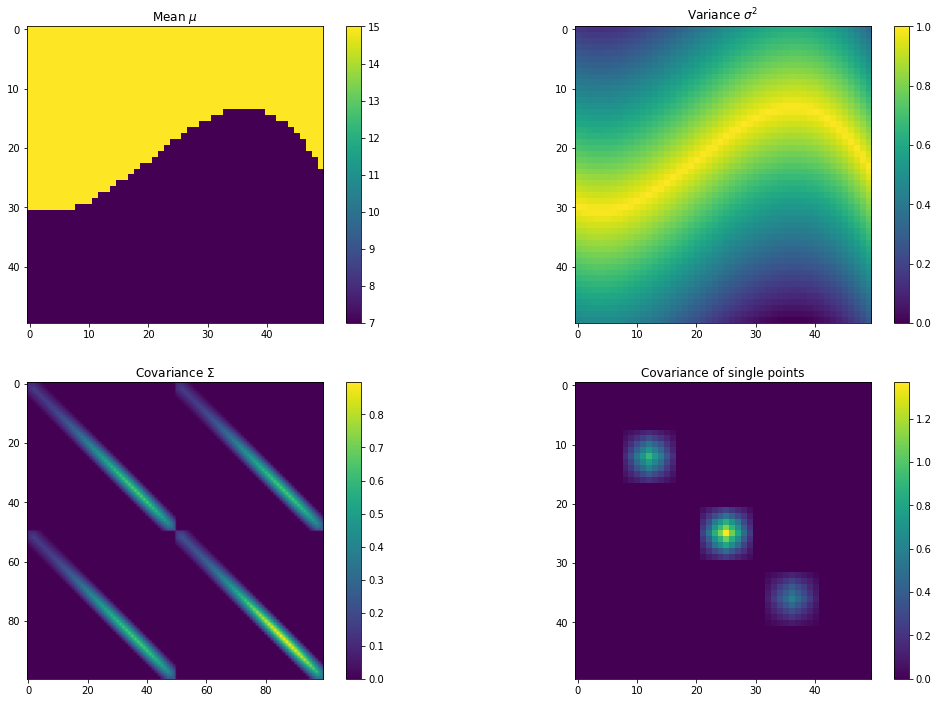

In [161]:
x = np.arange(50)
y = np.arange(50)
xx, yy = np.meshgrid(x, y)

mean, variance = generate_normal(xx, yy)
covariance = build_covariance_matrix(variance+0.01, [2.0, 1.0, 1.0])

impulse = np.zeros_like(mean)
impulse[mean.shape[0]//4*3, mean.shape[1]//4*3] = 1.0
impulse[mean.shape[0]//2, mean.shape[1]//2] = 1.0
impulse[mean.shape[0]//4, mean.shape[1]//4] = 1.0
impulse = impulse.flatten()

plt.figure(figsize=(18,12))
plt.subplot(2,2,1)
plt.title('Mean $\mu$')
plt.imshow(mean)
plt.colorbar()

plt.subplot(2,2,2)
plt.title('Variance $\sigma^2$')
plt.imshow(variance)
plt.colorbar()

plt.subplot(2,2,3)
plt.title('Covariance $\Sigma$')
plt.imshow(covariance[:100,:100])
plt.colorbar()

plt.subplot(2,2,4)
plt.title('Covariance of single points')
plt.imshow( (impulse @ covariance).reshape(mean.shape) )
plt.colorbar()

plt.show()

## Multivariate probability density function
$$
    \displaystyle \operatorname {f} (\mathbf {X} ) = (2\pi )^{-n/2}|\mathbf {\Sigma } |^{-1/2}\exp \left(-{\tfrac {1}{2}}\mathbf {(X-\mu )^{\rm {T}}\Sigma ^{-1}(X-\mu )} \right) \\
    {\displaystyle \mathbf {\mu =\operatorname {E} [X]} } \\
    |\Sigma| = det(\Sigma)
$$

In [ ]:
# TODO

#### Sample

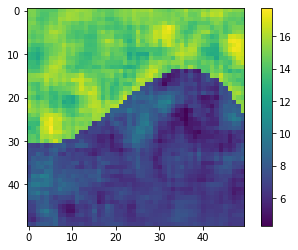

In [160]:
sample = np.random.multivariate_normal(mean.flatten(), covariance)

plt.figure()
plt.imshow(sample.reshape(mean.shape))
plt.colorbar()
plt.show()